In [1]:
import torch
from torch.utils.data import Dataset

In [2]:
import os
from PIL import Image
import numpy as np

In [3]:
class DogCat(Dataset):
    def __init__(self, root):
        imgs = os.listdir(root)  # 所有图片的绝对路径表
        # 不实际加载图片，只指定路径，当调用 __getitem__ 时才读取图片，以节省内存
        self.imgs = [os.path.join(root, img) for img in imgs]

    def __getitem__(self, index):
        img_path = self.imgs[index]
        # 标签设置：dog -> 1， cat -> 0
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        # 真正读取图片
        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = torch.tensor(array)  # 转为张量
        return data, label

    def __len__(self):
        return len(self.imgs)  # 返回样本数

In [4]:
# 读取数据集
dataset = DogCat('./data/cat_dog/')  # 图片存储在 ./data/cat_dog/ 文件夹内

In [12]:
dataset

In [7]:
# 获取第一个数据，包含标签和图片
img, label = dataset[0]  # 相当于调用dataset.__getitem__(0)

In [10]:
print(img.shape)  # torch.Size([374, 500, 3]) 说明图片已转为张量
print(label)  # 0 说明是 cat

torch.Size([374, 500, 3])
0


In [14]:
for img, label in dataset:
    print("tensor's shape: {}, label: {}".format(img.shape, label))

tensor's shape: torch.Size([374, 500, 3]), label: 0
tensor's shape: torch.Size([199, 187, 3]), label: 1
tensor's shape: torch.Size([375, 499, 3]), label: 1
tensor's shape: torch.Size([287, 300, 3]), label: 1
tensor's shape: torch.Size([376, 499, 3]), label: 1
tensor's shape: torch.Size([315, 499, 3]), label: 0
tensor's shape: torch.Size([258, 448, 3]), label: 0
tensor's shape: torch.Size([267, 320, 3]), label: 0


In [15]:
# transforms
from torchvision import transforms

In [16]:
transform = transforms.Compose([
    transforms.Resize(224),  # 缩放图片 (PIL Image), 保持长宽比不变, 使最短边缩放到 224 像素
    transforms.CenterCrop(224),  # 从图片中间切出 224x224 的图片
    transforms.ToTensor(),  # 将图片 (PIL Image) 转成 Tensor , 自动归一化至 [0, 1]
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])  # 标准化至 [-1, 1] , 规定均值和标准差 , 因为图片为 3 维
])

In [21]:
class DogCat(Dataset):
    def __init__(self, root, transform=None):
        imgs = os.listdir(root)  # 所有图片的绝对路径表
        # 不实际加载图片，只指定路径，当调用 __getitem__ 时才读取图片，以节省内存
        self.imgs = [os.path.join(root, img) for img in imgs]
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.imgs[index]
        # 标签设置：dog -> 1， cat -> 0
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        # 真正读取图片
        data = Image.open(img_path)
        if self.transform:
            data = self.transform(data)
        return data, label

    def __len__(self):
        return len(self.imgs)  # 返回样本数

In [22]:
# 读取数据集
dataset = DogCat('./data/cat_dog/', transform=transform)  # 使用 transform 进行变换

In [23]:
for img, label in dataset:
    print(img.shape, label)

torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0


In [28]:
no_transform = DogCat('./data/cat_dog/')
img, label = no_transform[0]

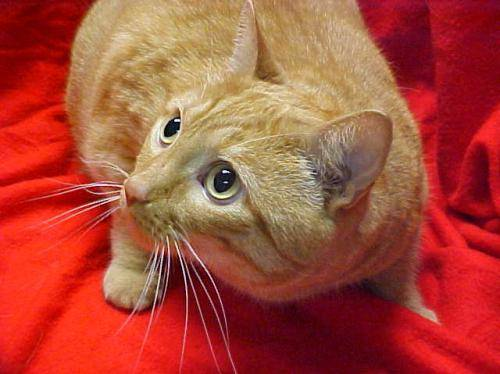

In [29]:
img

In [30]:
# ImageFolder

In [31]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder('./data/cat_dog_imagefolder')

In [33]:
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [34]:
dataset.imgs

[('./data/cat_dog_imagefolder/cat/cat.13.jpg', 0),
 ('./data/cat_dog_imagefolder/cat/cat.14.jpg', 0),
 ('./data/cat_dog_imagefolder/cat/cat.16.jpg', 0),
 ('./data/cat_dog_imagefolder/cat/cat.18.jpg', 0),
 ('./data/cat_dog_imagefolder/dog/dog.2.jpg', 1),
 ('./data/cat_dog_imagefolder/dog/dog.3.jpg', 1),
 ('./data/cat_dog_imagefolder/dog/dog.4.jpg', 1),
 ('./data/cat_dog_imagefolder/dog/dog.5.jpg', 1)]

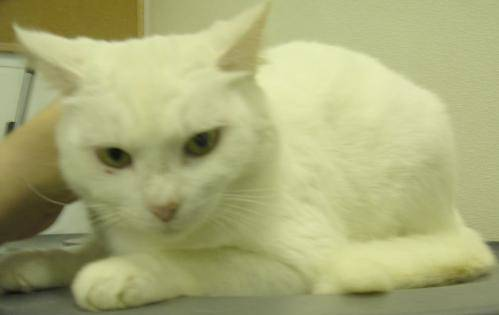

In [50]:
dataset.__getitem__(0)[0]

In [53]:
def get_class_by_idx(idx):
    for key_class, val_idx in dataset.class_to_idx.items():
        if val_idx == idx:
            return key_class
    return 'Not found'


print("The label is: {} meaning {}".format(
    dataset.__getitem__(0)[1],
    get_class_by_idx(dataset[0][1])
))

The label is: 0 meaning cat


In [54]:
# 加入变换
dataset = ImageFolder('./data/cat_dog_imagefolder', transform=transform)

In [55]:
dataset.__getitem__(0)[0].shape

torch.Size([3, 224, 224])

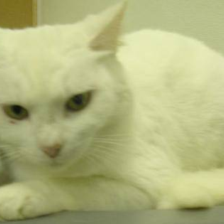

In [57]:
to_img = transforms.ToPILImage()
to_img(dataset[0][0] * 0.5 + 0.5)

In [58]:
dataset

Dataset ImageFolder
    Number of datapoints: 8
    Root location: ./data/cat_dog_imagefolder
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [68]:
# dataloader
from torch.utils.data import DataLoader

dataset = DogCat('./data/cat_dog/', transform=transform)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, drop_last=False)

In [69]:
for img_batch, label_batch in dataloader:
    print(img_batch.shape, label_batch.shape)

torch.Size([3, 3, 224, 224]) torch.Size([3])
torch.Size([3, 3, 224, 224]) torch.Size([3])
torch.Size([2, 3, 224, 224]) torch.Size([2])


In [73]:
dataiter = iter(dataloader)
imgs, labels = next(dataiter)
print(imgs.shape)  # torch.Size([3, 3, 224, 224])

torch.Size([3, 3, 224, 224])


In [72]:
# 迭代器补充
a = [1, 2, 3]
b = iter(a)
print(next(b))
print(next(b))

1
2


In [74]:
# 读取失败
dataset = DogCat('./data/cat_dog_fail/', transform=transform)

In [78]:
# 报错 : UnidentifiedImageError: cannot identify image file
# for img, label in dataset:
#     print(img.shape, label)

In [79]:
class NewDogCat(DogCat):  # 继承之前自定义的 Dataset 类 DogCat
    # 修改 __getitem__() 方法
    def __getitem__(self, index):
        try:
            # 调用父类的真正读取图片的方法 __getitem__() 等价于 DogCat.__getitem__(self, index)
            return super().__getitem__(index)
        except:
            # 数据=None, 标签=None
            return None, None

In [80]:
from torch.utils.data.dataloader import default_collate  # 导入 Dataloader 默认的拼接方式


def delete_fail_sample(batch):
    # batch 是一个 list，每个元素是 dataset 的返回值，形如 (data, label)
    batch = [_ for _ in batch if _[0] is not None]  # 过滤为 None 的数据
    if len(batch) == 0:
        return torch.Tensor()  # 如果整个数据集都是空的
    return default_collate(batch)  # 用默认方式拼接过滤后的batch数据

In [89]:
dataset = NewDogCat('data/cat_dog_fail/', transform=transform)

In [98]:
dataset[5]

(None, None)

In [102]:
dataloader = DataLoader(dataset, 2, collate_fn=delete_fail_sample, num_workers=0, shuffle=True, drop_last=False)
for img_batch, label_batch in dataloader:
    print(img_batch.shape, label_batch.shape)

torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])
torch.Size([1, 3, 224, 224]) torch.Size([1])


In [109]:
import random


# 随机读取数据
class NewDogCat(DogCat):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except:
            new_index = random.randint(0, len(self) - 1)  # 随机返回一张正常数据
            return self[new_index]

In [106]:
dataset = NewDogCat('data/cat_dog_fail/', transform=transform)
dataloader = DataLoader(dataset, 2, collate_fn=None, num_workers=0, shuffle=True, drop_last=False)
for img_batch, label_batch in dataloader:
    print(img_batch.shape, label_batch.shape)

torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([1, 3, 224, 224]) torch.Size([1])


In [134]:
# 权重采样
dataset = DogCat('data/cat_dog/', transform=transform)  # 总共 8 张图

# 设置权重：假设 cat 的图片被取出的概率是 dog 的概率的 2 倍
weights = [2 if label == 0 else 1 for data, label in dataset]  # 两类图片被取出的概率与 weights 的绝对大小无关，只和比值有关
weights  # [2, 1, 1, 1, 1, 2, 2, 2] -> cat (label=0) 设权重为 2 ; dog (label=1) 设权重为 1

[2, 1, 1, 1, 1, 2, 2, 2]

In [135]:
from torch.utils.data.sampler import WeightedRandomSampler

sampler = WeightedRandomSampler(weights=weights, num_samples=9, replacement=True)
dataloader = DataLoader(dataset, batch_size=3, sampler=sampler)

In [136]:
for datas, labels in dataloader:
    print(labels)

tensor([1, 0, 0])
tensor([1, 0, 1])
tensor([0, 0, 0])
